In [4]:
from sklearn.metrics import f1_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

def train_evaluate_classifier_f1(train_data, test_data):
    base_estimator = DecisionTreeClassifier(max_depth=1)

    adaboost_clf = AdaBoostClassifier(estimator=base_estimator)
    clf = adaboost_clf

    x_train = train_data.drop(["label"], axis=1)
    x_test = test_data.drop(["label"], axis=1)

    y_train = train_data["label"]
    y_test = test_data["label"]

    assert 'label' not in x_train.columns
    assert 'noisy_label' not in x_train.columns
    assert 'mislabeling_probability' not in x_train.columns

    assert 'label' not in x_test.columns
    assert 'noisy_label' not in x_test.columns
    assert 'mislabeling_probability' not in x_test.columns


    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)

    return (f1_score(y_test, y_pred))

In [5]:
def compute_required_proportions(corrupted_data, number_of_mislabeled_instances, precision, recall):
    precision = 0.00001 if precision == 0 else precision
    tp  = round(recall * number_of_mislabeled_instances)
    fn = round(number_of_mislabeled_instances - tp)
    fp = round((tp / precision) - tp)
    tn = len(corrupted_data) - tp - fn - fp

    return tp, fn, fp, tn


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import math

datasets = [
    "../../datasets/music/music_most_values_svm_corrupted.csv",
    "../../datasets/music/music_most_values_tree_corrupted.csv",
    "../../datasets/music/music_most_values_rf_corrupted.csv",
]

per_dataset_results = []

for dataset in datasets:
    music = pd.read_csv(dataset)

    train_data, test_data = train_test_split(music, test_size=0.2)
    test_data = test_data.drop(["noisy_label"], axis=1)

    baseline_f1 = train_evaluate_classifier_f1(train_data.drop("label", axis=1).rename(columns={"noisy_label": "label"}), test_data)

    artificially_cleaned_datasets = []

    permutations = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

    mislabeled_instances = train_data[train_data["label"] != train_data["noisy_label"]]
    clean_instances = train_data[train_data["label"] == train_data["noisy_label"]]

    for precision_value in permutations:
        for recall_value in permutations:
            current_train_data = train_data.copy()
            tp, fn, fp, tn = compute_required_proportions(current_train_data, len(mislabeled_instances), precision_value, recall_value)

            assert math.isclose((tp) / ((tp) + (fn)), recall_value, abs_tol=0.01)
            assert math.isclose(precision_value, (tp) / ((tp) + (fp)), abs_tol=0.01)


            cleaned_mislabeled = mislabeled_instances.sample(n=len(mislabeled_instances) - tp)
            cleaned_clean = clean_instances.sample(n=len(clean_instances) - fp)

            cleaned_dataset = pd.concat([cleaned_mislabeled, cleaned_clean], ignore_index=True).sample(frac=1).reset_index(drop=True)
            cleaned_dataset = cleaned_dataset.drop("label", axis=1).rename(columns={"noisy_label": "label"})

            artificially_cleaned_datasets.append((precision_value, recall_value, cleaned_dataset))

    results = []

    for precision_value, recall_value, cleaned_dataset in artificially_cleaned_datasets:
        print(precision_value, recall_value)
        result = train_evaluate_classifier_f1(cleaned_dataset, test_data)

        results.append((precision_value, recall_value, result, result - baseline_f1))

    per_dataset_results.append(results)

0.1 0.1
0.1 0.2
0.1 0.3
0.1 0.4
0.1 0.5
0.1 0.6
0.1 0.7
0.1 0.8
0.1 0.9
0.1 1
0.2 0.1
0.2 0.2
0.2 0.3
0.2 0.4
0.2 0.5
0.2 0.6
0.2 0.7
0.2 0.8
0.2 0.9
0.2 1
0.3 0.1
0.3 0.2
0.3 0.3
0.3 0.4
0.3 0.5
0.3 0.6
0.3 0.7
0.3 0.8
0.3 0.9
0.3 1
0.4 0.1
0.4 0.2
0.4 0.3
0.4 0.4
0.4 0.5
0.4 0.6
0.4 0.7
0.4 0.8
0.4 0.9
0.4 1
0.5 0.1
0.5 0.2
0.5 0.3
0.5 0.4
0.5 0.5
0.5 0.6
0.5 0.7
0.5 0.8
0.5 0.9
0.5 1
0.6 0.1
0.6 0.2
0.6 0.3
0.6 0.4
0.6 0.5
0.6 0.6
0.6 0.7
0.6 0.8
0.6 0.9
0.6 1
0.7 0.1
0.7 0.2
0.7 0.3
0.7 0.4
0.7 0.5
0.7 0.6
0.7 0.7
0.7 0.8
0.7 0.9
0.7 1
0.8 0.1
0.8 0.2
0.8 0.3
0.8 0.4
0.8 0.5
0.8 0.6
0.8 0.7
0.8 0.8
0.8 0.9
0.8 1
0.9 0.1
0.9 0.2
0.9 0.3
0.9 0.4
0.9 0.5
0.9 0.6
0.9 0.7
0.9 0.8
0.9 0.9
0.9 1
1 0.1
1 0.2
1 0.3
1 0.4
1 0.5
1 0.6
1 0.7
1 0.8
1 0.9
1 1
0.1 0.1
0.1 0.2
0.1 0.3
0.1 0.4
0.1 0.5
0.1 0.6
0.1 0.7
0.1 0.8
0.1 0.9
0.1 1
0.2 0.1
0.2 0.2
0.2 0.3
0.2 0.4
0.2 0.5
0.2 0.6
0.2 0.7
0.2 0.8
0.2 0.9
0.2 1
0.3 0.1
0.3 0.2
0.3 0.3
0.3 0.4
0.3 0.5
0.3 0.6
0.3 0.7
0.3 0.8
0.3 0.9
0.3 1
0.4 0.

In [7]:
for results in per_dataset_results:
    df = pd.DataFrame(results, columns=["precision", "recall", "f1", "diff"])

    corr_with_f1 = df.corr()["f1"].drop("f1")
    print(corr_with_f1)

precision    0.075251
recall       0.864965
diff         1.000000
Name: f1, dtype: float64
precision    0.050244
recall       0.729654
diff         1.000000
Name: f1, dtype: float64
precision   -0.068526
recall       0.705067
diff         1.000000
Name: f1, dtype: float64


In [8]:
labeled = []

labeled.append(('RF', per_dataset_results[2]))
labeled.append(('Tree', per_dataset_results[1]))
labeled.append(('LSVC', per_dataset_results[0]))

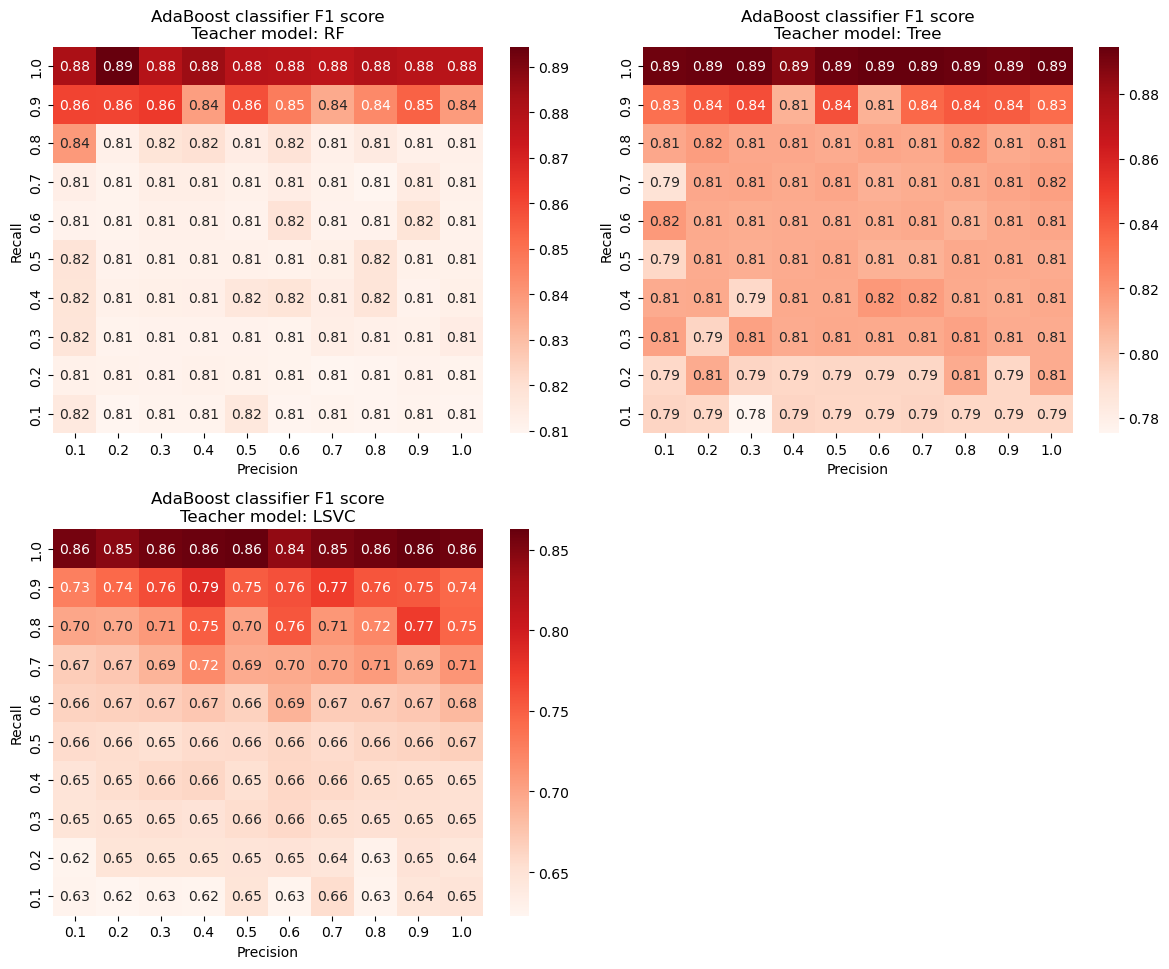

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

precision_vals = np.round(np.arange(0.1, 1.1, 0.1), 1)
recall_vals = np.round(np.arange(0.1, 1.1, 0.1), 1)

num_plots = len(per_dataset_results)
ncols = 2
nrows = int(np.ceil(num_plots / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows))

axes = axes.flatten()

for idx, (label, results) in enumerate(labeled):
    matrix = np.zeros((len(recall_vals), len(precision_vals)))

    for px, ry, val, _ in results:
        i = np.where(recall_vals == ry)[0][0]
        j = np.where(precision_vals == px)[0][0]
        matrix[i, j] = val

    sns.heatmap(matrix,
                ax=axes[idx],
                xticklabels=precision_vals,
                yticklabels=recall_vals,
                cmap="Reds",
                annot=True, fmt=".2f")

    axes[idx].invert_yaxis()
    axes[idx].set_xlabel("Precision")
    axes[idx].set_ylabel("Recall")
    axes[idx].set_title(f"AdaBoost classifier F1 score\nTeacher model: {label}")

for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
